# Brain substructures' volume


In this notebook:

* we compute volumes of meshes for different substructures and subjects

* we compare volumes obtained using different segmentation tools

In [1]:
import numpy as np
import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
from matplotlib import pyplot as plt
from polpo.binarizer import StageBinarizer
from polpo.preprocessing import (
    BranchingPipeline,
    IndexMap,
    NestingSwapper,
)
from polpo.preprocessing.load.fsl import get_all_first_structs
from polpo.preprocessing.load.pregnancy.jacobs import (
    MeshLoader,
    TabularDataLoader,
)
from polpo.sklearn.compose import BinarizedEstimator
from sklearn.linear_model import LinearRegression

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
DEBUG = False

## Volume (``enigma`` meshes)

### Loading data

In [3]:
structs = get_all_first_structs(include_brstem=False, order=True)

if DEBUG:
    n_unique_structs = 2
    left_structs = filter(lambda struct: struct.startswith("L_"), structs)
    right_structs = filter(lambda struct: struct.startswith("R_"), structs)

    structs = [next(left_structs) for _ in range(n_unique_structs)] + [
        next(right_structs) for _ in range(n_unique_structs)
    ]


print(structs)

['L_Accu', 'L_Amyg', 'L_Caud', 'L_Hipp', 'L_Pall', 'L_Puta', 'L_Thal', 'R_Accu', 'R_Amyg', 'R_Caud', 'R_Hipp', 'R_Pall', 'R_Puta', 'R_Thal']


In [4]:
subject_subset = ["01"] if DEBUG else None

mesh_loader = MeshLoader(
    subject_subset=subject_subset,
    struct_subset=structs,
    as_mesh=True,
    derivative="enigma",
) + ppdict.DictMap(ppdict.NestedDictSwapper())

# subject, struct, session
raw_meshes = mesh_loader()

In [5]:
pipe = TabularDataLoader()

df = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/maternal/maternal_brain_project_pilot/rawdata/28Baby_Hormones.csv').


In [6]:
predictor_selector = ppd.GroupByColumn("subject", as_dict=True) + ppdict.DictMap(
    ppd.IndexSetter("sessionID", drop=True)
    + ppd.ColumnsSelector("gestWeek")
    + ppd.SeriesToDict()
)

x_dict = predictor_selector(df)

### Merge left and right

In [7]:
def _merger(data):
    left_meshes, right_meshes = data

    meshes = {}
    struct_merger = ppdict.DictMerger(step=lambda x: x[0] + x[1], as_dict=True)

    for left_key, left_meshes_struct in left_meshes.items():
        struct_name = left_key[2:]
        right_meshes_struct = right_meshes[f"R_{struct_name}"]
        meshes[struct_name] = struct_merger((left_meshes_struct, right_meshes_struct))

    return meshes


mesh_joiner = BranchingPipeline(
    [
        ppdict.DictFilter(lambda key: key.startswith("L"), filter_keys=True),
        ppdict.DictFilter(lambda key: key.startswith("R"), filter_keys=True),
    ],
    merger=_merger,
)
concat_meshes = ppdict.DictMap(mesh_joiner)(raw_meshes)

for subj_id, subj_dict in raw_meshes.items():
    subj_dict.update(concat_meshes[subj_id])

### Plot volumes 

In [9]:
dataset_pipe = (
    ppdict.DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x), index=0)
)

bin2plot = StageBinarizer(merge_pre_preg=True)
bin2color = ["blue", "red"]

model = BinarizedEstimator(LinearRegression(fit_intercept=True), bin2plot)


def plot_volumes_subject(subject_id, meshes):
    _, axes = plt.subplots(
        nrows=2 + 1,
        ncols=len(structs) // 2,
        sharex=False,
        sharey=False,
        squeeze=True,
        figsize=(30, 12),
        dpi=150,
    )
    if not isinstance(axes[0], np.ndarray):
        axes = [[ax] for ax in axes]

    for pos, (struct_name, meshes_struct) in enumerate(meshes.items()):
        # TODO: fix lims per struct?
        # TODO: break axes? see brokenaxes

        col_index = pos % (len(structs) // 2)
        row_index = 2 if "_" not in struct_name else int(struct_name.startswith("L"))
        ax = axes[row_index][col_index]

        x, meshes_ = dataset_pipe((x_dict[subject_id], meshes_struct))

        volumes = [mesh.volume for mesh in meshes_]

        bin_x, bin_volumes = bin2plot(x, volumes)

        for x_, volumes_, color in zip(bin_x, bin_volumes, bin2color):
            ax.scatter(x_, volumes_, color=color)

        model.fit(x[:, None], volumes)
        x_pred = np.linspace(min(x), max(x))
        volume_pred = model.predict(x_pred[:, None])
        bin_x_pred, bin_volume_pred = bin2plot(x_pred, volume_pred)

        for x_, volumes_, color in zip(bin_x_pred, bin_volume_pred, bin2color):
            ax.plot(x_, volumes_, color=color)

        if col_index == 0:
            ax.set_ylabel("Volume")

        if row_index == 2:
            ax.set_xlabel("Gestational week")

        ax.set_title(f"{struct_name}")

    plt.suptitle(subject_id)

    plt.show()

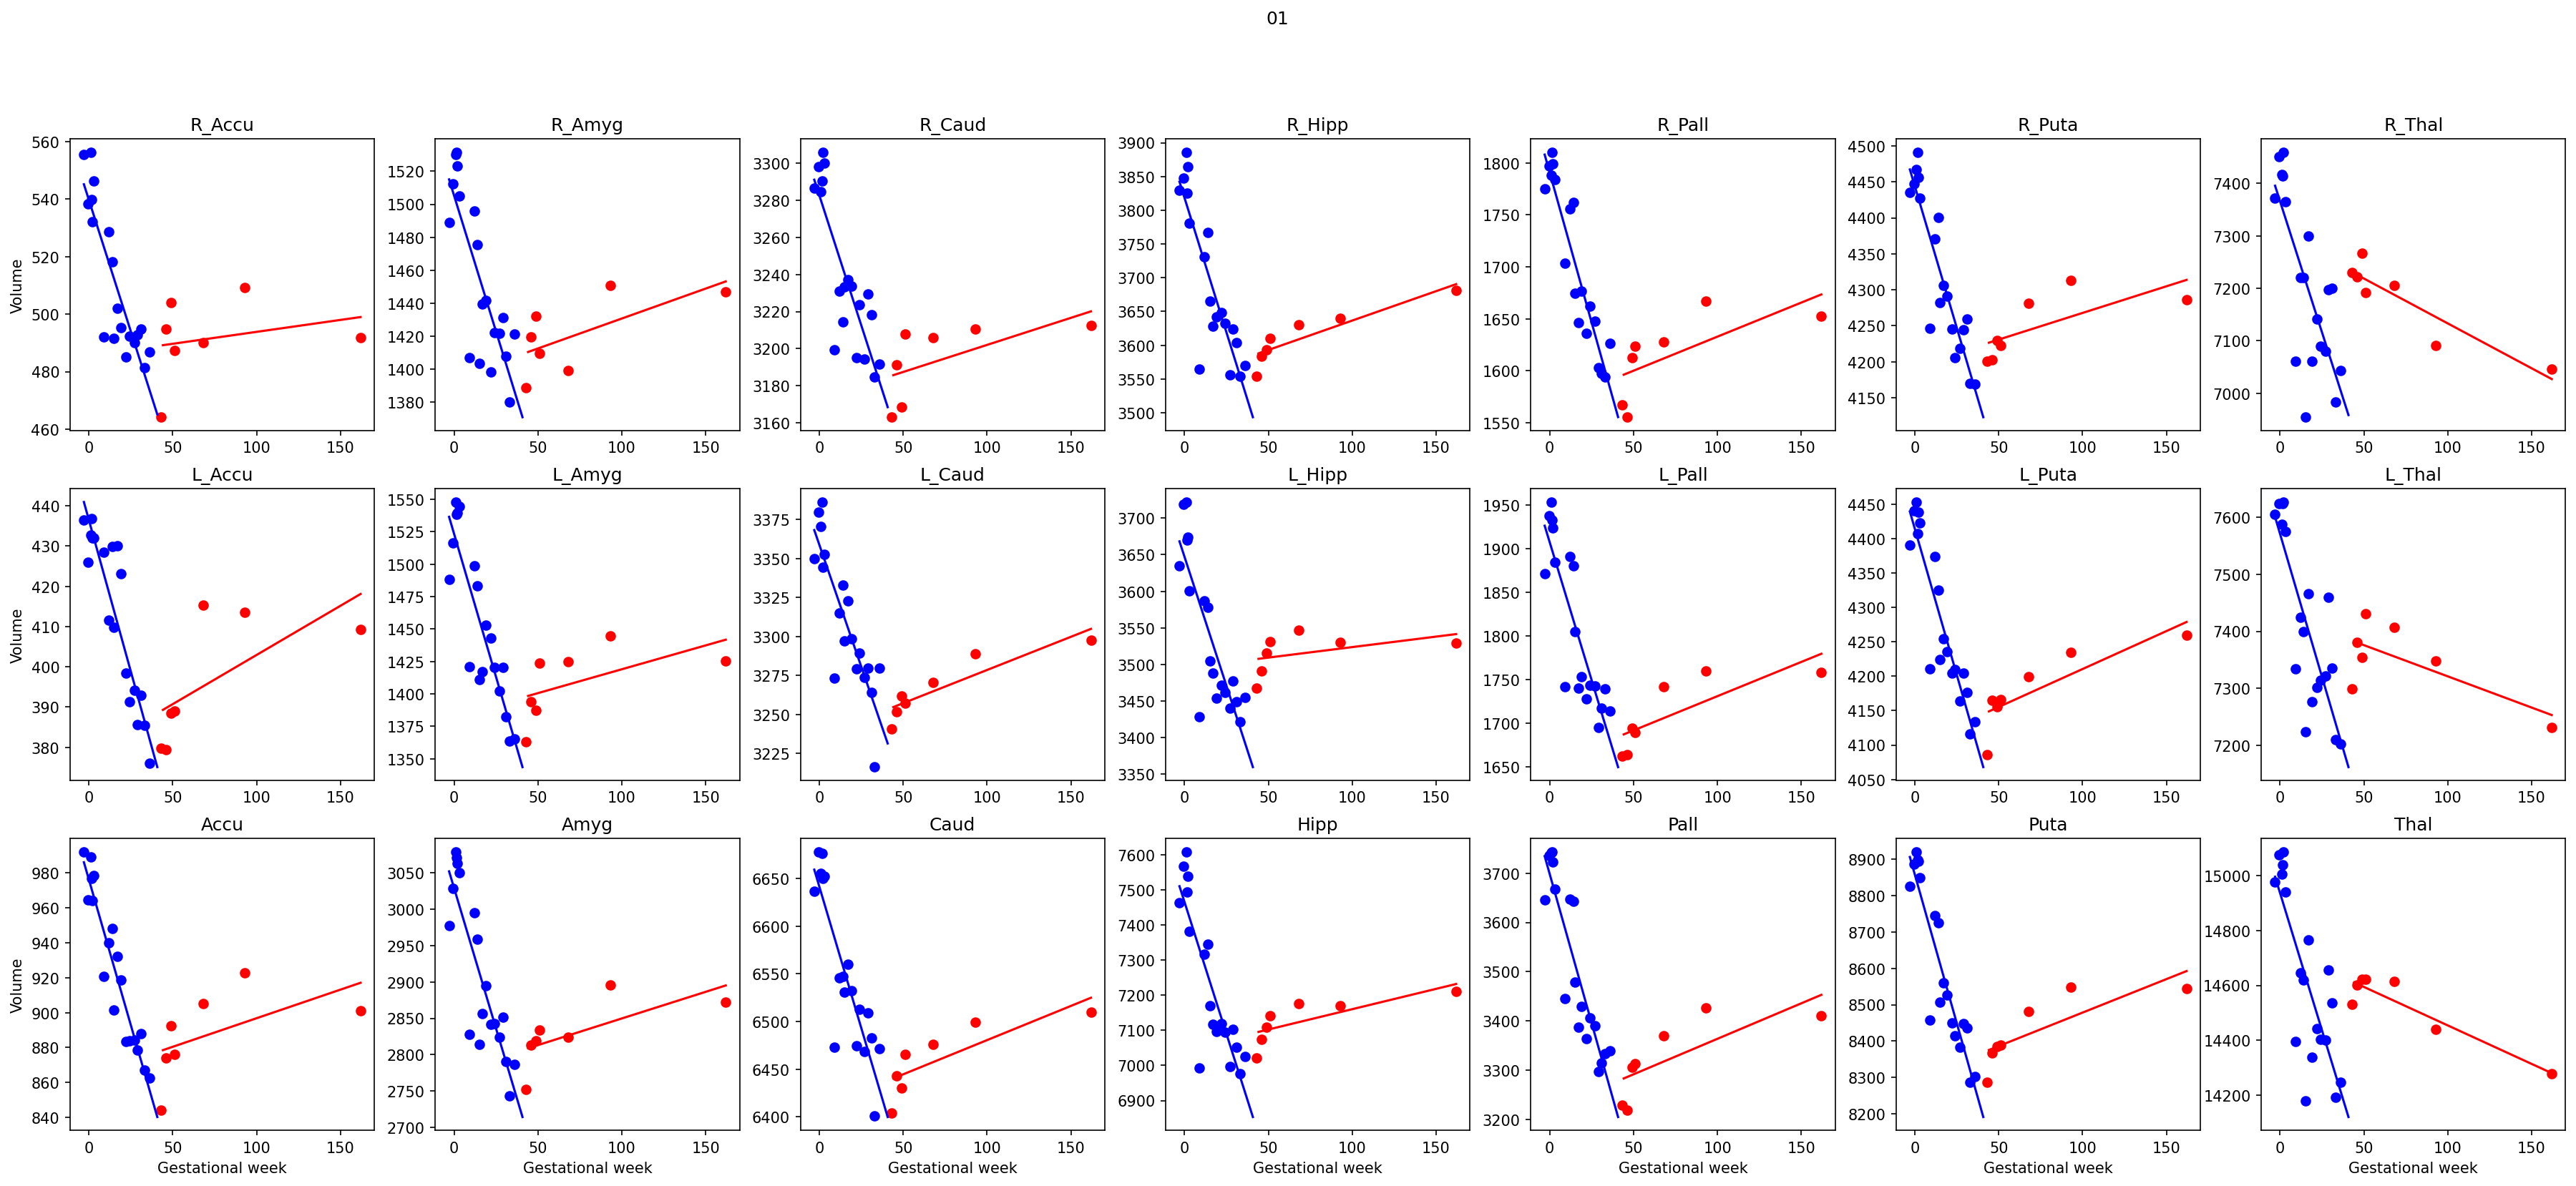

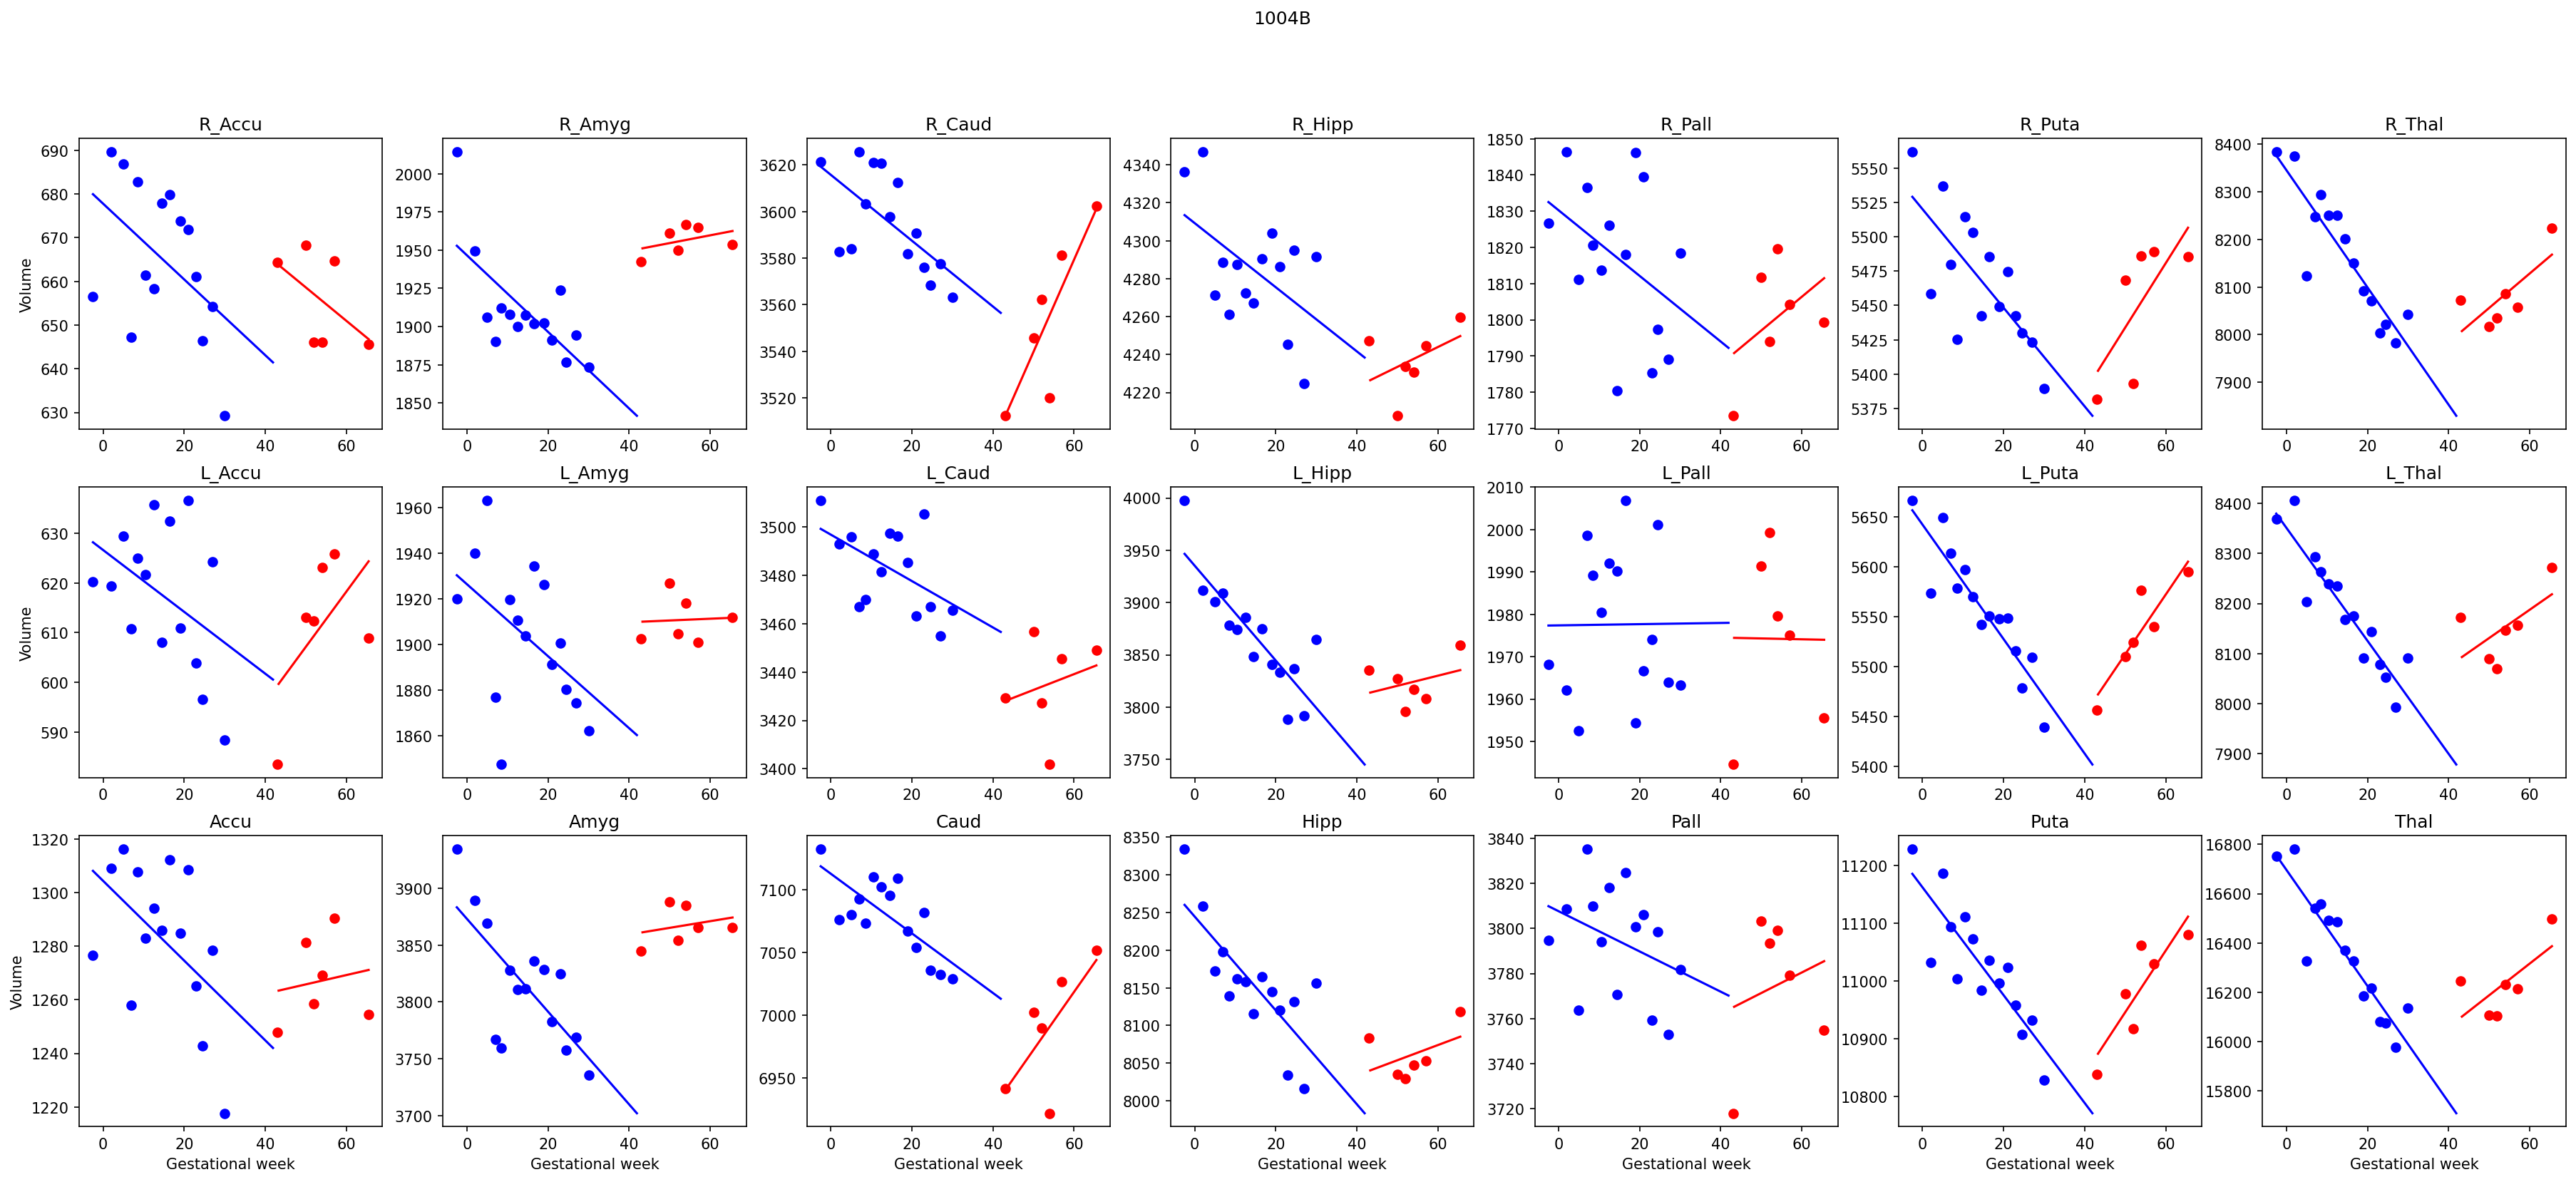

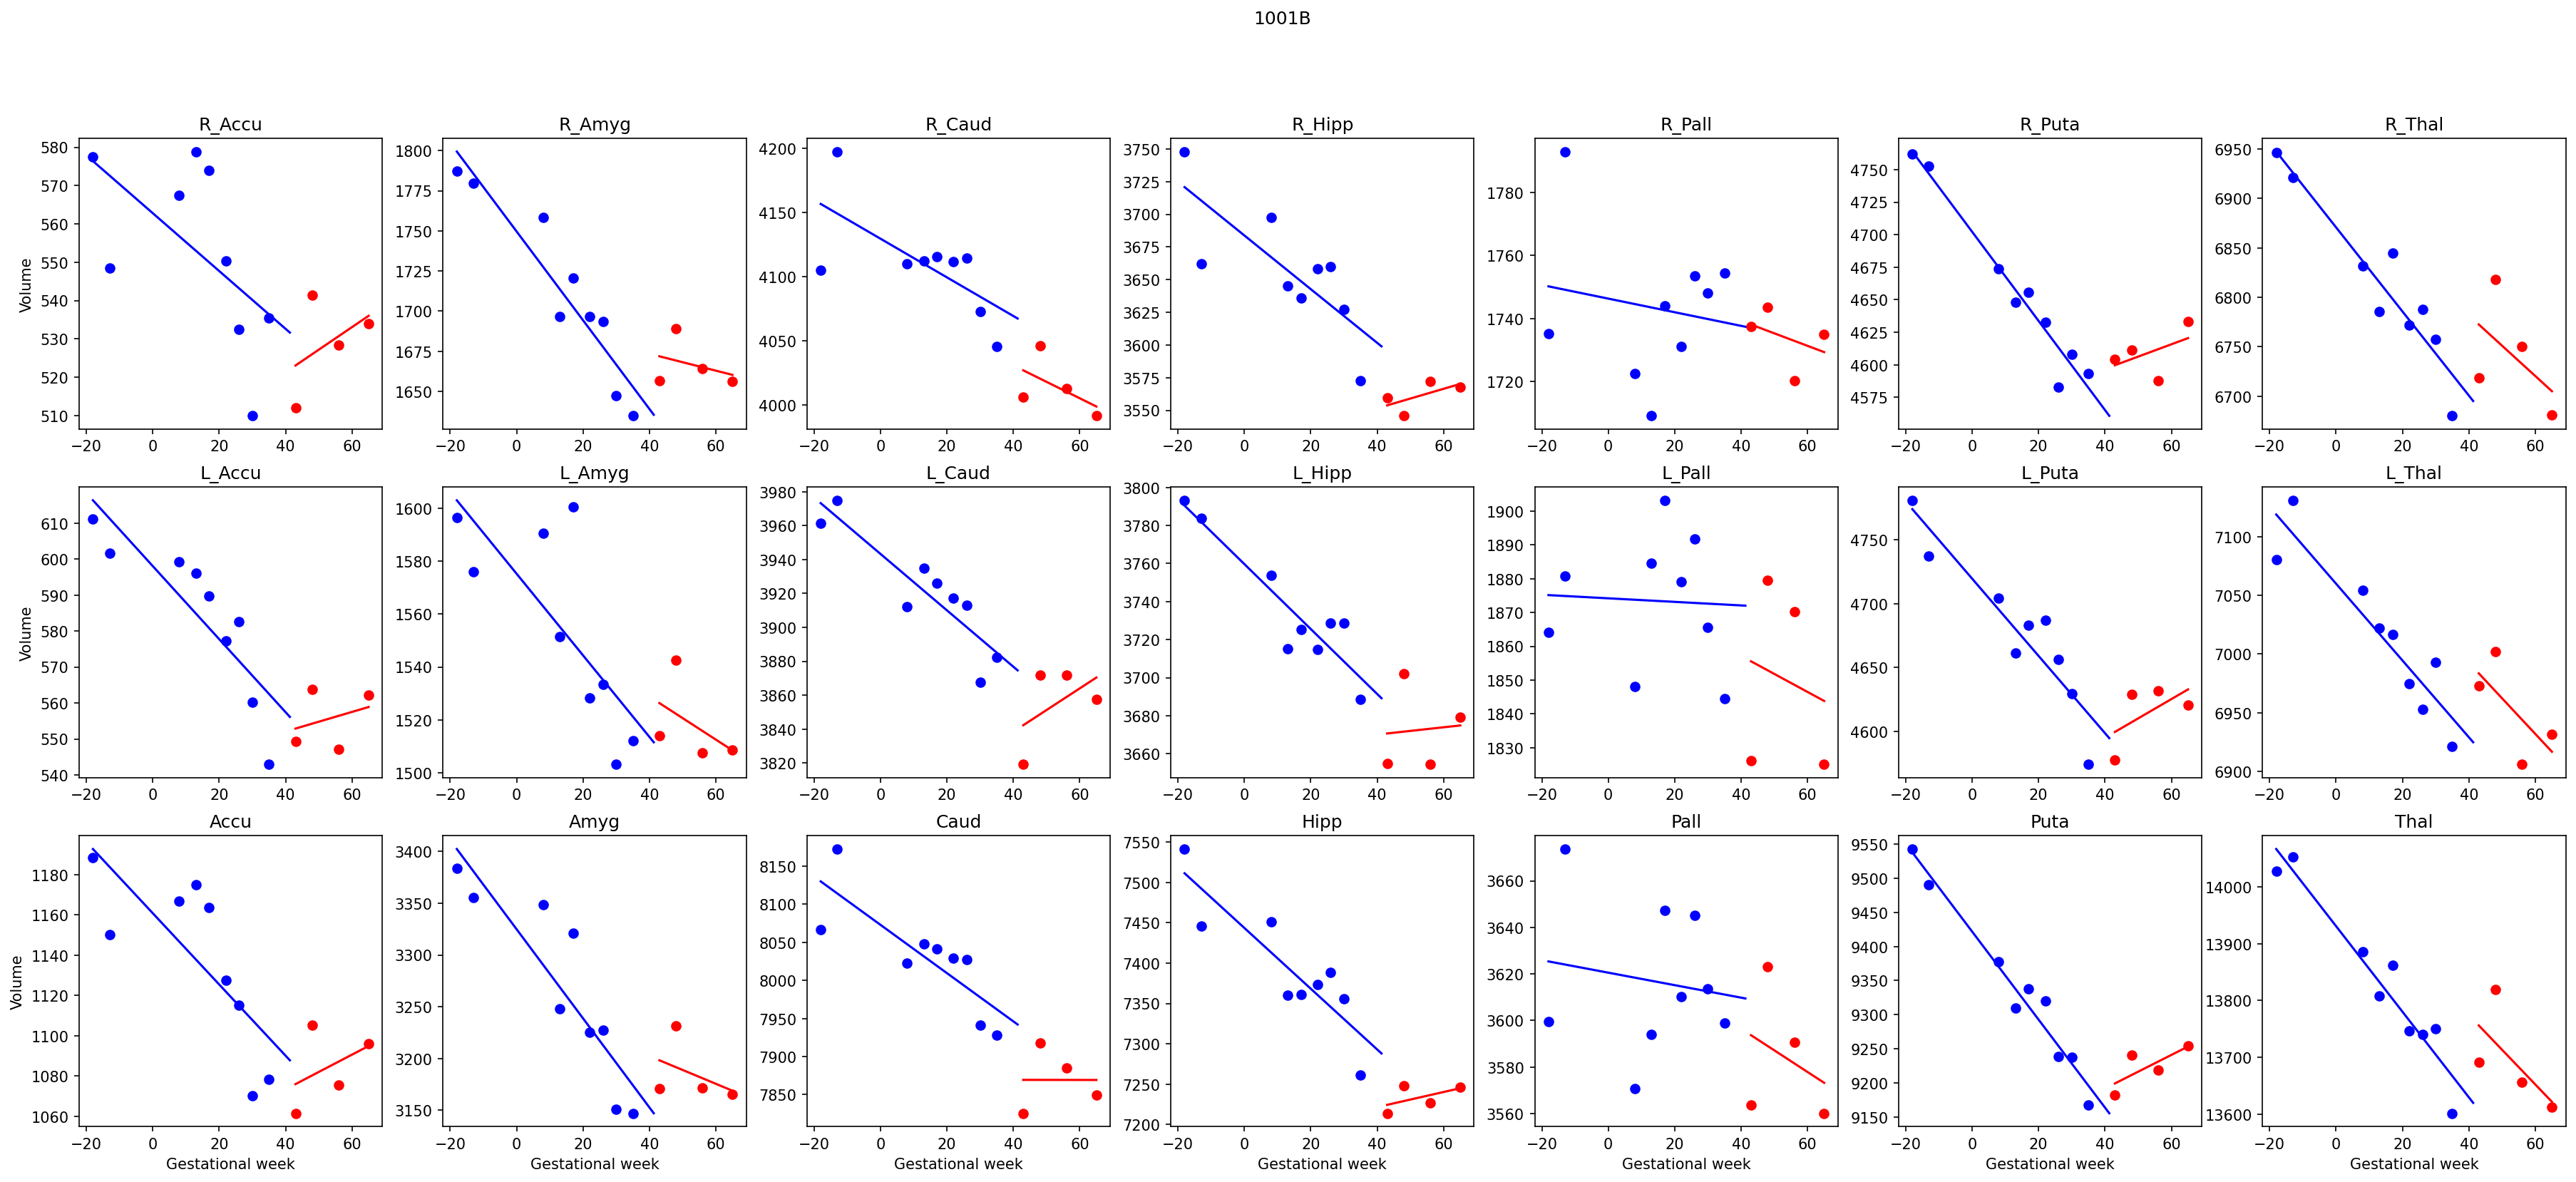

In [10]:
for subject_id, meshes in raw_meshes.items():
    plot_volumes_subject(subject_id, meshes)

## Volume (``fsl_first`` meshes)

In [11]:
subject_subset = ["01"] if DEBUG else None

# subject, struct, session
mesh_loader = MeshLoader(
    subject_subset=subject_subset,
    struct_subset=structs,
    as_mesh=True,
    derivative="fsl",
) + ppdict.DictMap(ppdict.NestedDictSwapper())

raw_meshes = mesh_loader()


concat_meshes = ppdict.DictMap(mesh_joiner)(raw_meshes)

for subj_id, subj_dict in raw_meshes.items():
    subj_dict.update(concat_meshes[subj_id])

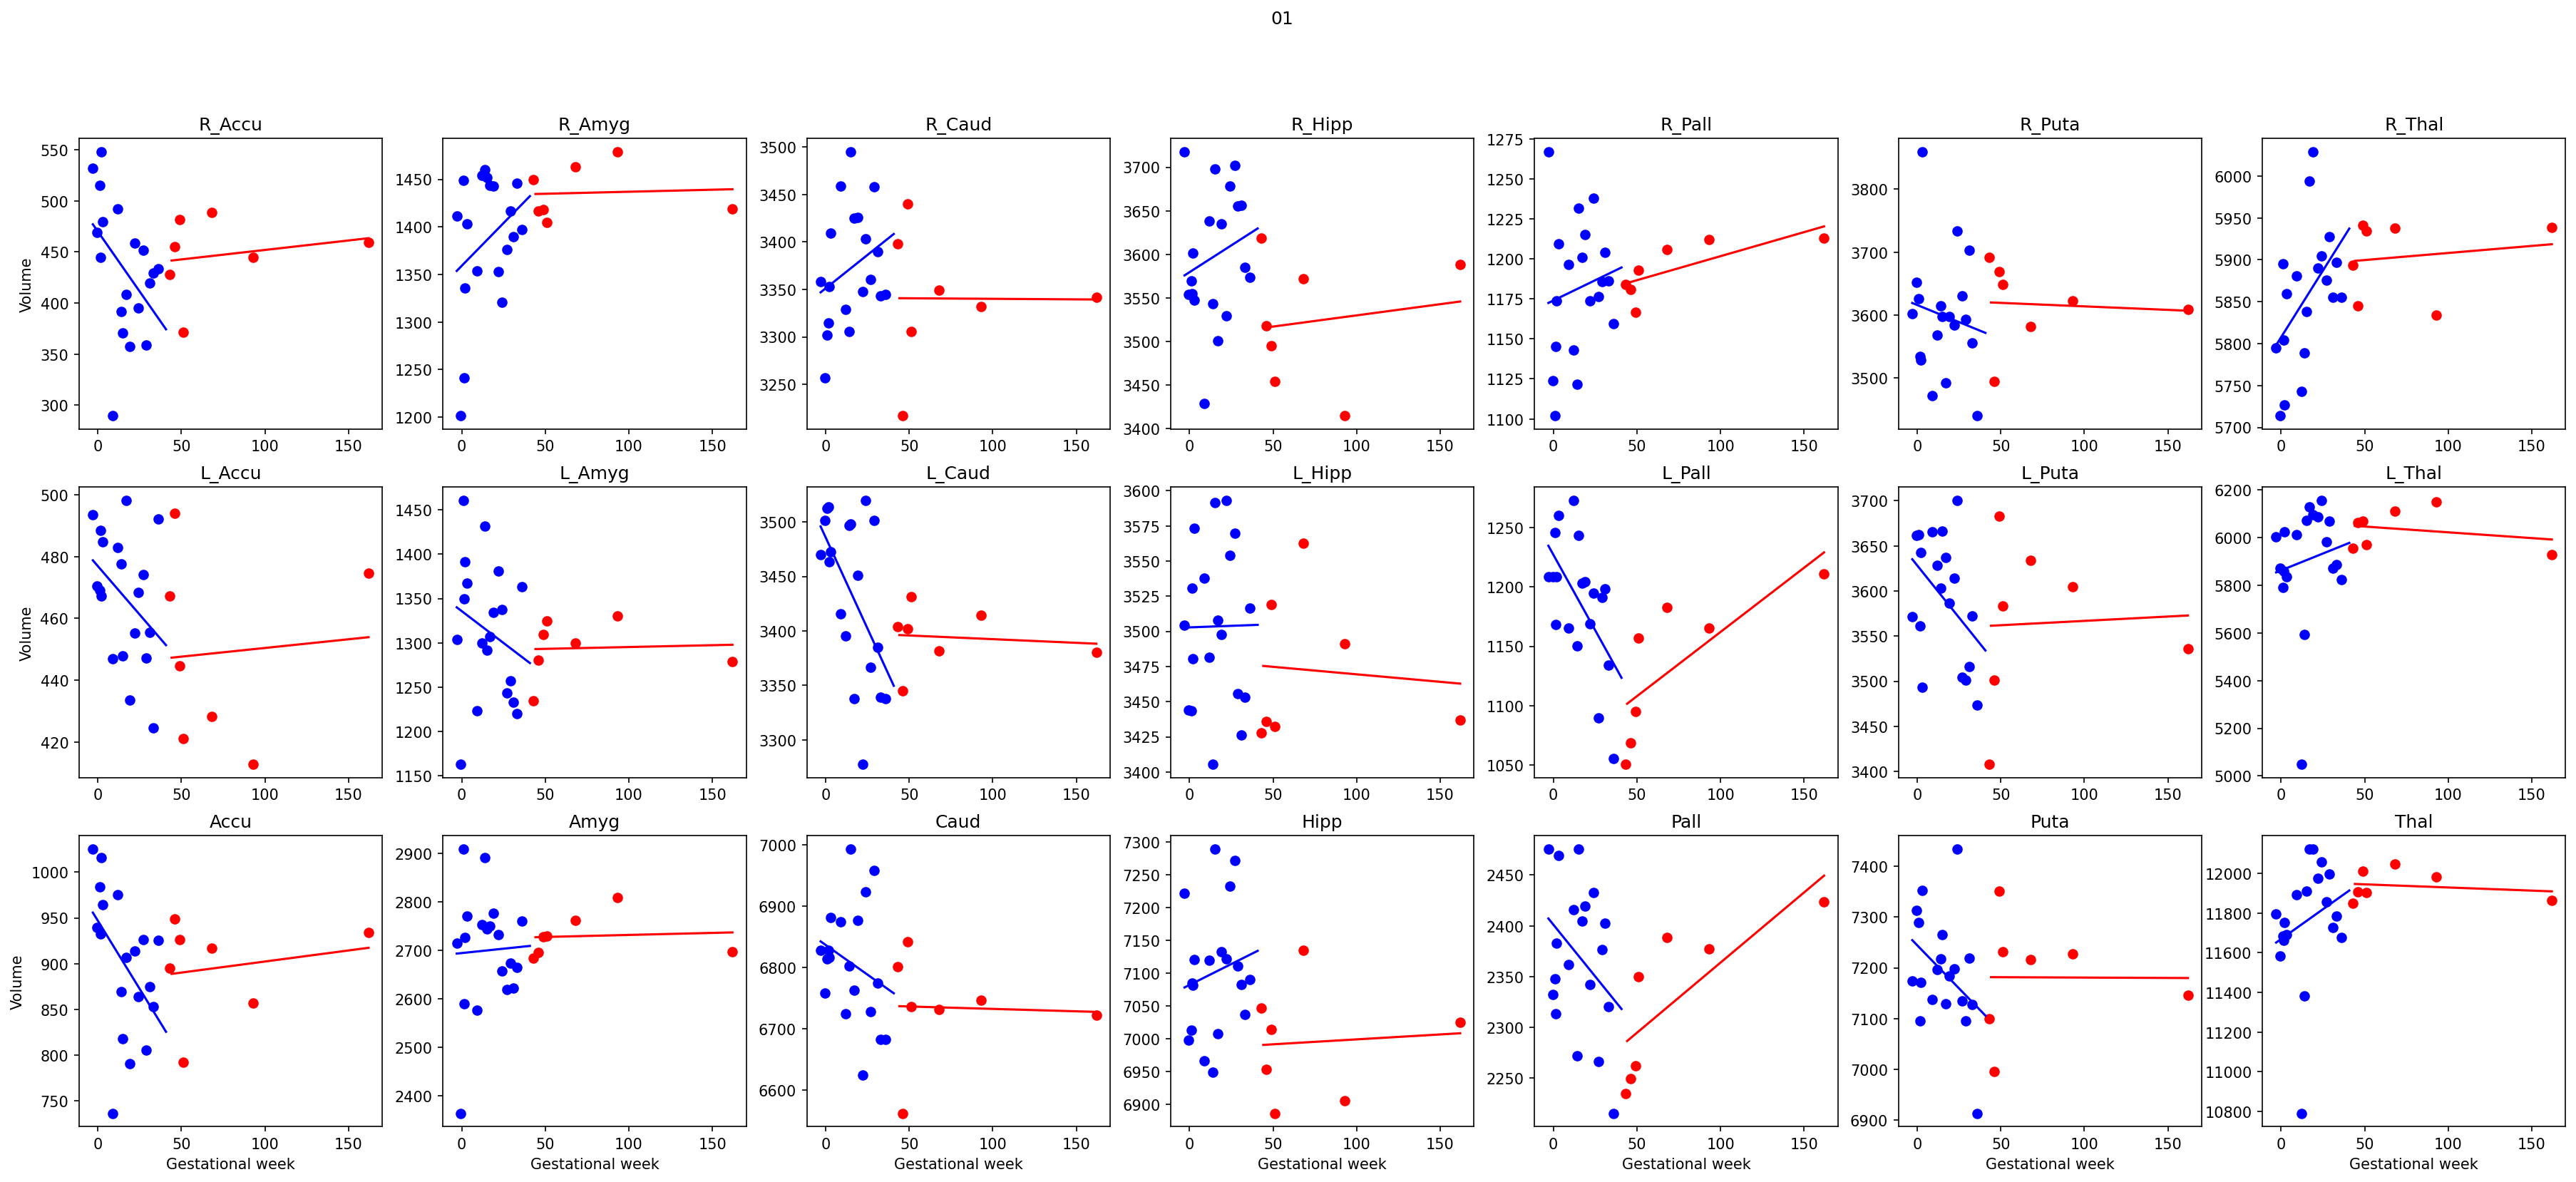

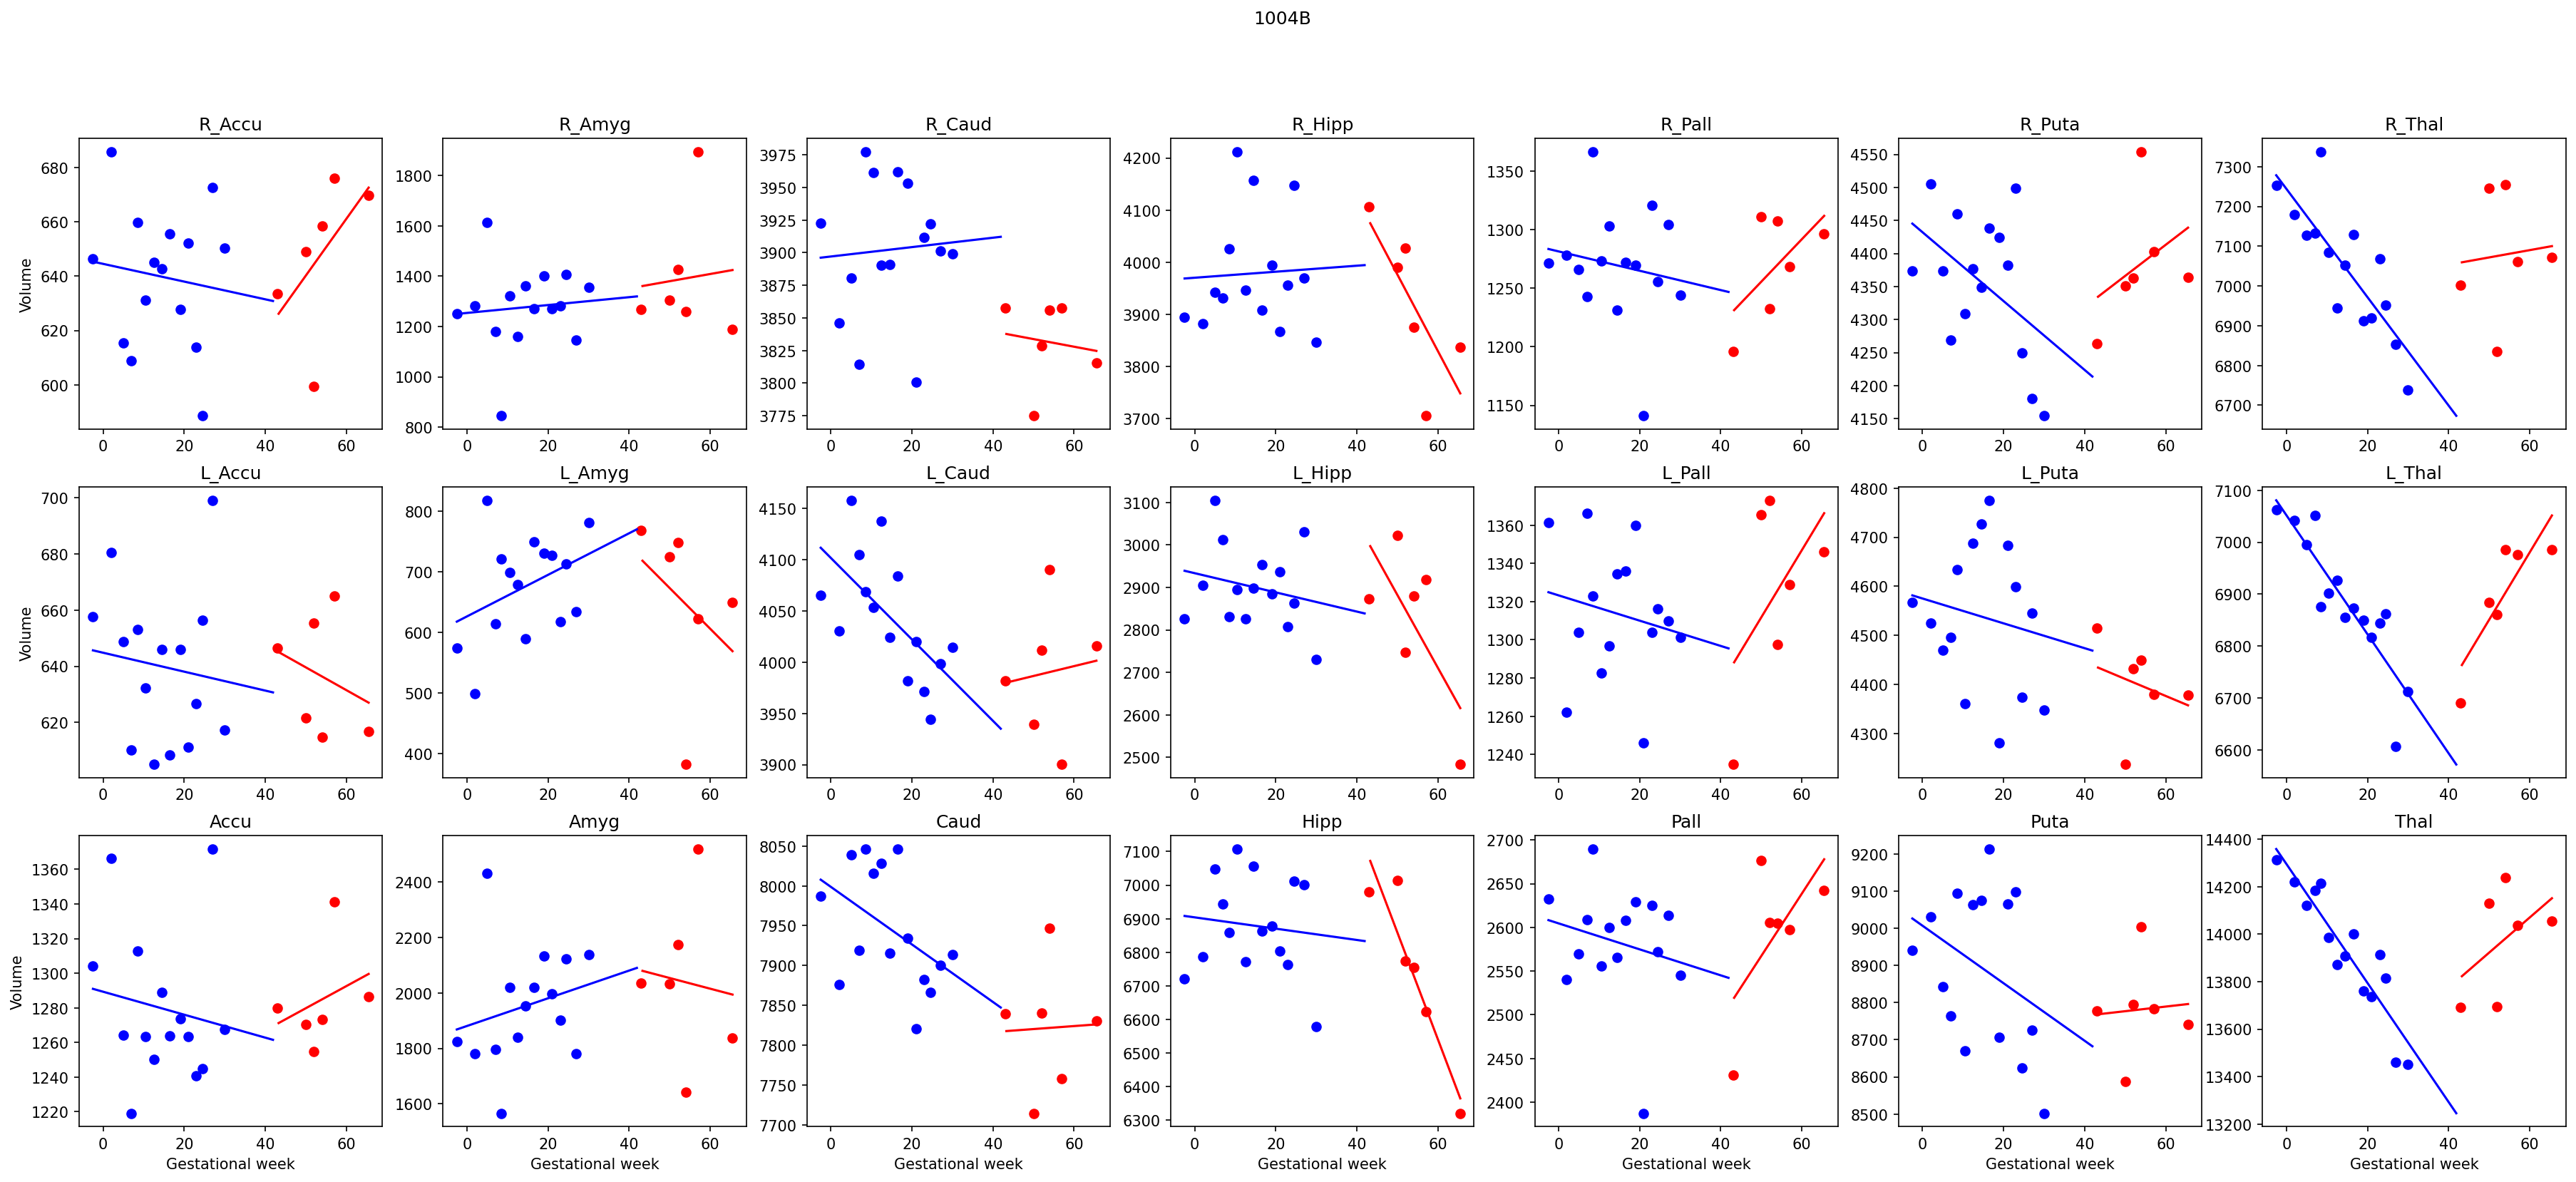

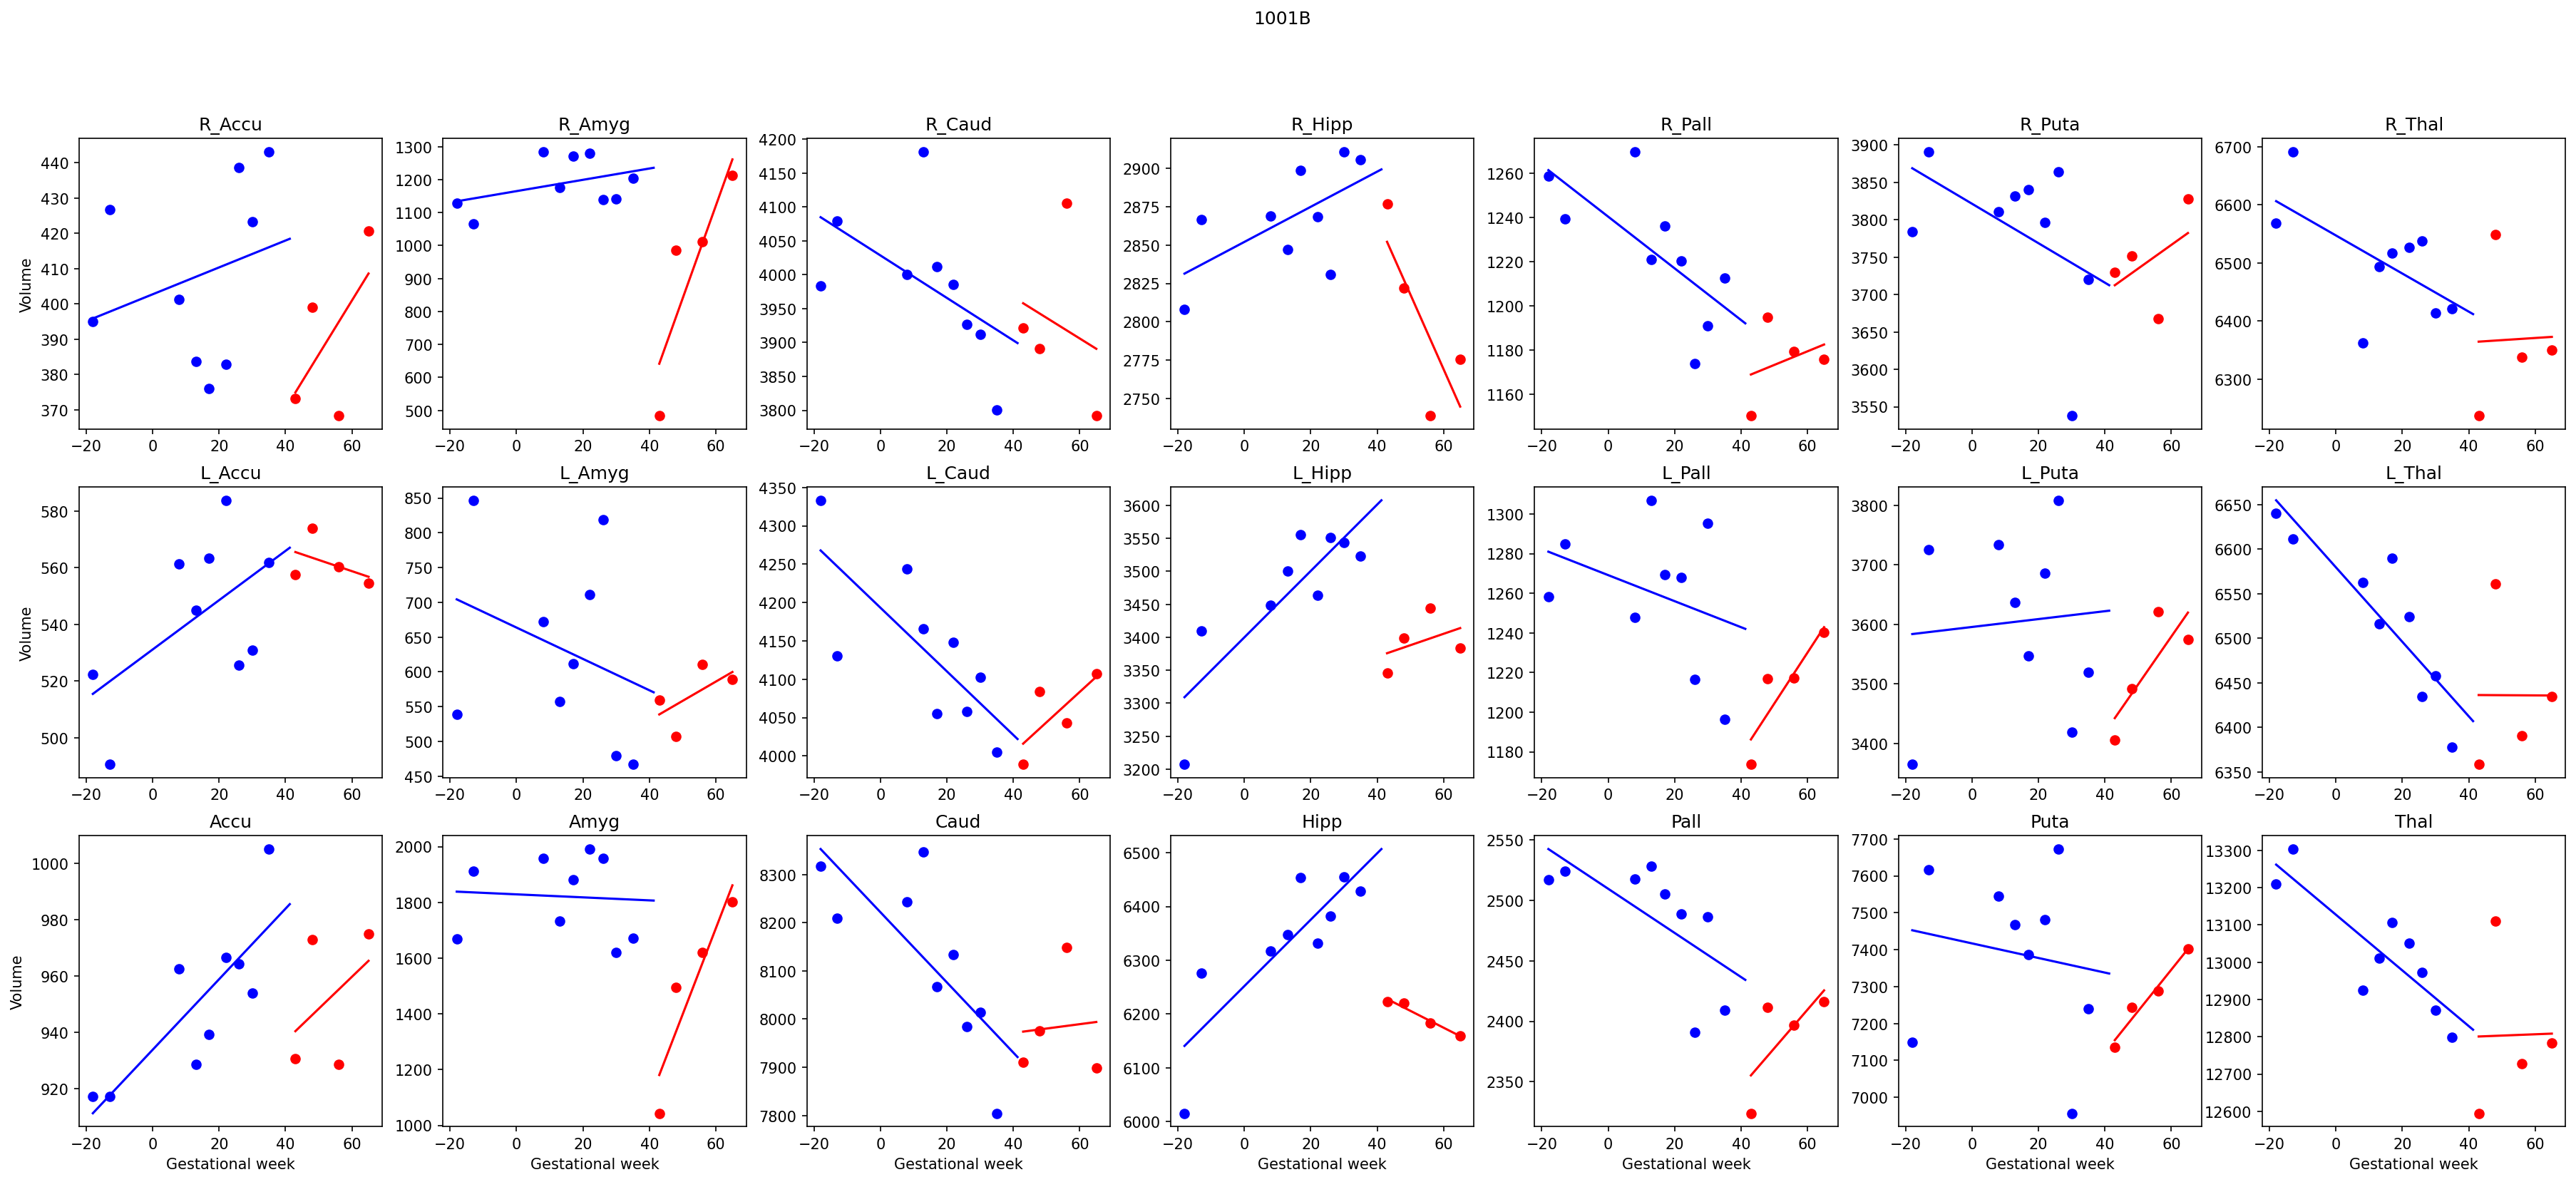

In [12]:
for subject_id, meshes in raw_meshes.items():
    plot_volumes_subject(subject_id, meshes)